## Prerequisites
- python==2.7    
- torch==1.0.0    
- matplotlib==2.0.0   
- torchsummary==1.5.1   

## 设置GPU使用
pytorch程序使用GPU需要将网络和数据传入至GPU。

In [13]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.tensor(1).cuda()

cuda:0


tensor(1, device='cuda:0')

## cifar10数据集
cifar10数据集图片为rgb类型，大小为32x32，包含下图10个类别。
![png](https://pytorch.org/tutorials/_images/cifar10.png)


## 加载数据
pytorch提供``torchvision``包来加载常见的数据集如Imagenet, CIFAR10, MNIST等，同时还提供可视化、数据转换等功能。

In [14]:
import torchvision
import torchvision.transforms as transforms

In [15]:
print(torch.version.cuda)

11.3


In [16]:
# torchvision导入的image tensor值域在[0, 1]，此处将其标准化到值域 [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## batch样例可视化

torch.Size([4, 3, 32, 32])


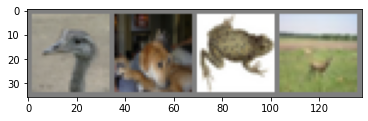

 bird   dog  frog  deer


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 该函数可视化一张图片
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 随机获取batch训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())

# 展示batch图片
imshow(torchvision.utils.make_grid(images))
# 打印batch label
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 定义网络结构

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        # 定义网络层
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3：输入channel，6输出channel，5：kernel size
        self.pool = nn.MaxPool2d(2, 2)  #2：kernel size，2：stride
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 定义前向网络结构
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # 打平tensor，-1表示任意size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)  

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 网络结构可视化
通过torchsummary包展示网络结构和参数量，Output Shape中的-1表示‘任意值’。

In [19]:
# from torchvision import models
# from torchsummary import summary
# summary(net, (3, 32, 32))

## 定义损失函数、优化方式

In [20]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
path = 'cifar.pt'

## 训练
在for loop函数中迭代生成数据并训练更新模型参数。

In [21]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 迭代生成训练数据并送入device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 梯度参数初始化为0
        optimizer.zero_grad()

        # 前向+后向+优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印训练log
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000batch打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
torch.save(net,path) 

[1,  2000] loss: 2.206
[1,  4000] loss: 1.853
[1,  6000] loss: 1.672
[1,  8000] loss: 1.577
[1, 10000] loss: 1.522
[1, 12000] loss: 1.465
[2,  2000] loss: 1.403
[2,  4000] loss: 1.396
[2,  6000] loss: 1.378
[2,  8000] loss: 1.342
[2, 10000] loss: 1.294
[2, 12000] loss: 1.297
Finished Training


In [22]:
net = torch.load(path)

## 测试

### 测试单个batch

torch.Size([4, 3, 32, 32])


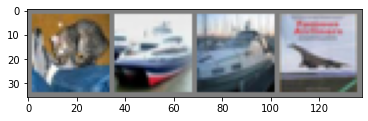

GroundTruth:    cat  ship  ship plane


In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print(images.size())

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
images= images.to(device)  
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [25]:
outputs

tensor([[ 0.1933, -1.0568,  0.8515,  1.3541,  0.0737,  0.2062, -0.4827, -1.3834,
          1.2940, -1.4787],
        [ 3.4314,  3.4611, -0.5231, -1.6244, -1.8835, -3.9052, -3.4984, -1.2719,
          4.1994,  2.3609],
        [ 2.0813,  2.1085,  0.3571, -1.0155, -0.4825, -2.6001, -2.3412, -0.6726,
          2.5048,  0.0802],
        [ 3.9755,  0.6477,  1.3181, -1.6575, -0.6694, -3.0610, -2.8803, -1.9484,
          5.2695, -1.2837]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 测试所有test图片
10个类别随机猜测准确率是10%，此处准确率有50%+证明模型有意义。

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


### 查看每类图片准确率

In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 50 %
Accuracy of   car : 67 %
Accuracy of  bird : 39 %
Accuracy of   cat : 51 %
Accuracy of  deer : 51 %
Accuracy of   dog : 20 %
Accuracy of  frog : 69 %
Accuracy of horse : 57 %
Accuracy of  ship : 83 %
Accuracy of truck : 45 %
